In [3]:
import matplotlib.pyplot as plt
import pandas as pd
import datetime as dt
import numpy as np
#import tensorflow as tf
from features import feature_engineering
import torch
import pandas as pd
import torch.nn as nn
import torch.optim as optim
import numpy as np
from torch.utils.data import DataLoader, TensorDataset
from sklearn.preprocessing import MinMaxScaler

In [4]:
start_date = dt.date(2016,1,1)
end_date = dt.date.today() - dt.timedelta(days=1)
df = feature_engineering.download_data('BTC-USD', start_date=start_date, end_date=end_date)

[*********************100%%**********************]  1 of 1 completed


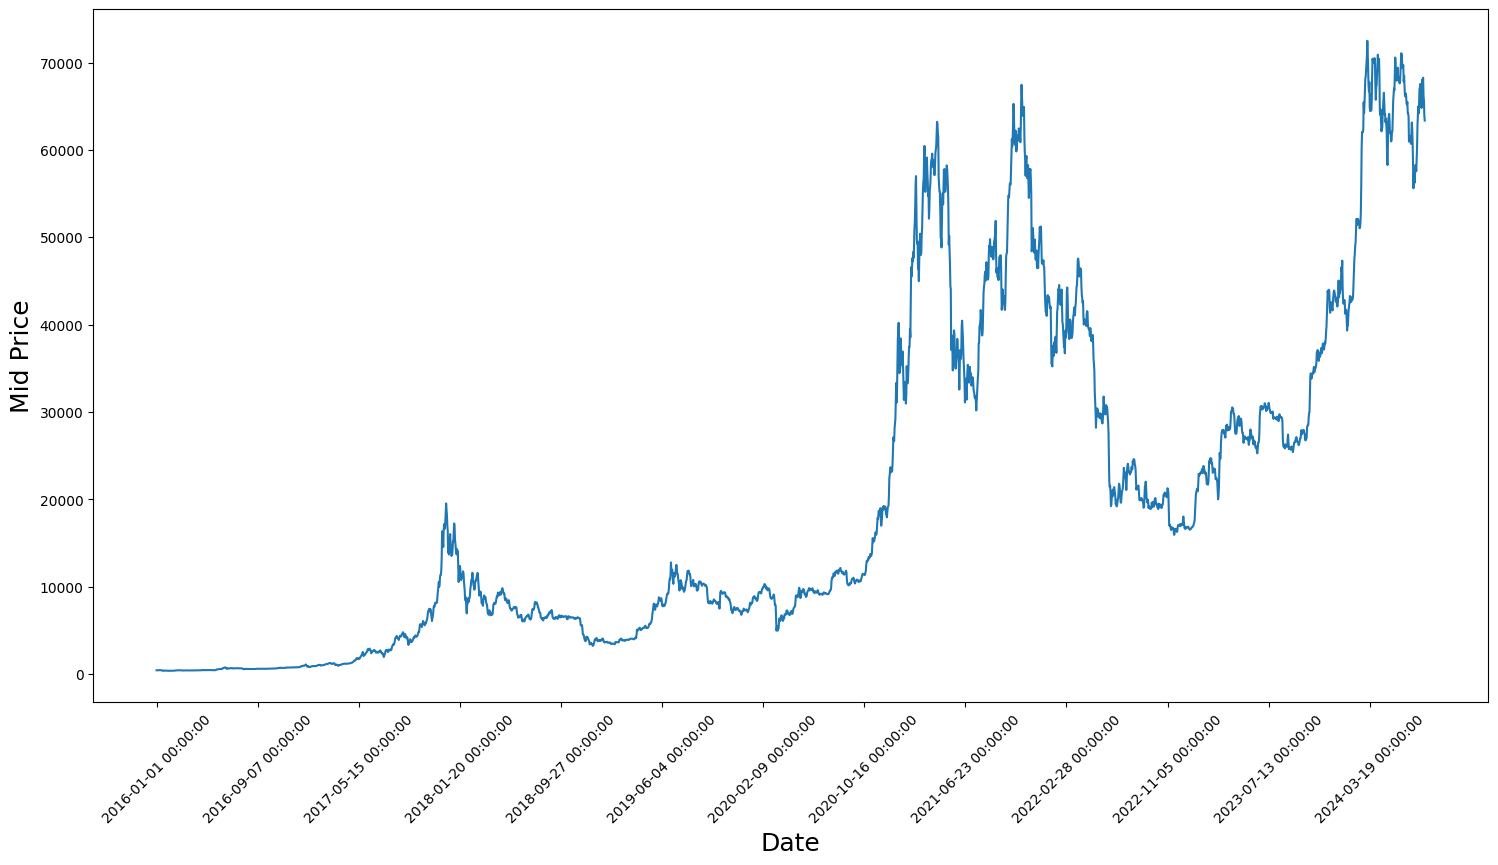

In [5]:
plt.figure(figsize = (18,9))
plt.plot(range(df.shape[0]),(df['low']+df['high'])/2.0)
plt.xticks(range(0,df.shape[0],250),df['date'].loc[::250],rotation=45)
plt.xlabel('Date',fontsize=18)
plt.ylabel('Mid Price',fontsize=18)
plt.show()

In [6]:
# First calculate the mid prices from the highest and lowest
high_prices = df.loc[:,'high'].values
low_prices = df.loc[:,'low'].values
mid_prices = (high_prices+low_prices)/2.0

In [7]:
# Normalize data
scaler = MinMaxScaler(feature_range=(-1, 1))
normalised_mid_prices = mid_prices.reshape(-1, 1)
normalised_mid_prices = scaler.fit_transform(normalised_mid_prices).reshape(-1)

In [8]:
normalised_mid_prices.shape

(3137,)

In [9]:
# Prepare sequences
sequence_length = 100
sequence_data = []
sequence_labels = []

for i in range(len(normalised_mid_prices) - sequence_length):
    sequence_data.append(normalised_mid_prices[i:i + sequence_length])
    sequence_labels.append(normalised_mid_prices[i + sequence_length])

sequence_data = np.array(sequence_data)
sequence_labels = np.array(sequence_labels)

In [10]:
# Split into train and test sets
train_data = sequence_data[:3000]
train_labels = sequence_labels[:3000]
test_data = sequence_data[3000:]
test_labels = sequence_labels[3000:]

In [11]:
# Convert to PyTorch tensors
train_data = TensorDataset(torch.from_numpy(train_data), torch.from_numpy(train_labels))
test_data = TensorDataset(torch.from_numpy(test_data), torch.from_numpy(test_labels))

train_loader = DataLoader(train_data, batch_size=32, shuffle=True)
test_loader = DataLoader(test_data, batch_size=32, shuffle=False)

In [12]:
# Define the model with dropout layers
class LSTMModel(nn.Module):
    def __init__(self, input_size, hidden_size, output_size, dropout_prob=0.2):
        super(LSTMModel, self).__init__()
        self.lstm = nn.LSTM(input_size, hidden_size, batch_first=True)
        self.dropout = nn.Dropout(p=dropout_prob)
        self.fc = nn.Linear(hidden_size, output_size)

    def forward(self, x):
        lstm_out, _ = self.lstm(x)
        lstm_out = self.dropout(lstm_out)
        out = self.fc(lstm_out[:, -1, :])
        return out

input_size = 1
hidden_size = 50
output_size = 1
dropout_prob = 0.2

model = LSTMModel(input_size, hidden_size, output_size, dropout_prob)

In [13]:
# Initializing Hyperparameters
epochs = 200
lr = 0.001  # Reduced learning rate

train_losses = []
test_losses = []

# Early stopping parameters
patience = 10
best_loss = float('inf')
epochs_no_improve = 0

# Define Loss Function and Optimizer
loss_mse = nn.MSELoss()
optimizer = optim.Adam(model.parameters(), lr=lr)

In [14]:
# Training Loop
for epoch in range(epochs):
    model.train()
    train_loss = 0

    for data, label in train_loader:
        data = data.unsqueeze(-1).float()
        label = label.unsqueeze(-1).float()

        optimizer.zero_grad()
        output = model(data)
        loss = loss_mse(output, label)
        loss.backward()
        optimizer.step()

        train_loss += loss.item()

    train_loss /= len(train_loader)
    train_losses.append(train_loss)

    # Early Stopping Check
    model.eval()
    val_loss = 0
    with torch.no_grad():
        for data, label in test_loader:
            data = data.unsqueeze(-1).float()
            label = label.unsqueeze(-1).float()
            output = model(data)
            loss = loss_mse(output, label)
            val_loss += loss.item()

    val_loss /= len(test_loader)
    test_losses.append(val_loss)

    if val_loss < best_loss:
        best_loss = val_loss
        epochs_no_improve = 0
        torch.save(model.state_dict(), 'best_model.pth')
    else:
        epochs_no_improve += 1
        if epochs_no_improve >= patience:
            print(f'Early stopping at epoch {epoch + 1}')
            break

    if (epoch + 1) % 10 == 0:
        print(f'Epoch [{epoch + 1}/{epochs}], Train Loss: {train_loss:.4f}, Validation Loss: {val_loss:.4f}')

print('Training complete')
model.load_state_dict(torch.load('best_model.pth'))

Epoch [10/200], Train Loss: 0.0042, Validation Loss: 0.0045
Epoch [20/200], Train Loss: 0.0034, Validation Loss: 0.0037
Epoch [30/200], Train Loss: 0.0029, Validation Loss: 0.0027
Epoch [40/200], Train Loss: 0.0026, Validation Loss: 0.0030
Epoch [50/200], Train Loss: 0.0024, Validation Loss: 0.0020
Epoch [60/200], Train Loss: 0.0022, Validation Loss: 0.0031
Epoch [70/200], Train Loss: 0.0020, Validation Loss: 0.0020
Epoch [80/200], Train Loss: 0.0020, Validation Loss: 0.0012
Early stopping at epoch 86
Training complete


/var/folders/3m/6yf1r5jj69v13h9z_ttwp7ch0000gn/T/ipykernel_26632/2852362192.py:49: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  model.load_state_dict(torch.load('best_model

<All keys matched successfully>

In [16]:
# Define a function to predict using the model
def predict(model, test_loader):
    model.eval()
    predictions = []

    with torch.no_grad():
        for data, _ in test_loader:
            data = data.unsqueeze(-1).float()
            output = model(data)
            predictions.extend(output.squeeze().tolist())

    return predictions

# Predict on the test data
predictions = predict(model, test_loader)

# Invert scaling of predictions
predictions = np.array(predictions).reshape(-1, 1)
predictions = scaler.inverse_transform(predictions).reshape(-1)

print('Predictions:', predictions)

Predictions: [61045.24379057 61089.27175375 60718.90902608 60324.14888368
 61264.1284893  62724.90005499 62290.02344472 60533.26344082
 58227.86893741 55286.69525758 56484.32205064 56884.2273138
 56160.51686307 56928.92796821 58037.39630903 58144.22096538
 57458.61750553 58409.25271211 59988.91224359 62486.31173591
 63789.80250488 64699.61201643 63903.09832188 64770.32841301
 66374.59167985 66677.62080963 66963.68866412 66082.11069238
 65456.8044372  64192.08475365 66091.66591664 67480.33271982
 67212.86810897 67550.87718255 65622.38963936 64893.54911208
 63322.66680415]


Overfitting Issue
To address overfitting, consider:

Regularization: Add dropout layers or L2 regularization.
Adjust Learning Rate: Reduce the learning rate to avoid overfitting too quickly.
Early Stopping: Implement early stopping based on validation loss.
Data Augmentation: Increase the size of your training data if possible.

In [26]:
def forecast(model, data, sequence_length, steps_ahead):
    model.eval()
    
    # Ensure data is a numpy array and reshape it
    data = np.array(data)
    
    # Start with the last available sequence
    current_sequence = data[-sequence_length:].reshape(1, sequence_length, 1)
    predictions = []

    with torch.no_grad():
        for _ in range(steps_ahead):
            # Convert the sequence to a tensor
            input_seq = torch.tensor(current_sequence, dtype=torch.float32)
            
            # Make the prediction
            predicted_value = model(input_seq).item()
            
            # Append the prediction to the list
            predictions.append(predicted_value)
            
            # Update the sequence: append the new prediction and remove the oldest value
            new_sequence = np.append(current_sequence[0, 1:, :], [[predicted_value]], axis=0)
            current_sequence = new_sequence.reshape(1, sequence_length, 1)
    
    return predictions

# Combine train and test data for complete dataset
all_data = np.concatenate((train_data, test_data)).flatten()

# Forecast the next 2 days (assuming steps_ahead is in the same units as your time steps)
steps_ahead = 2
future_predictions = forecast(model, all_data, sequence_length, steps_ahead)

# Invert scaling of predictions
future_predictions = np.array(future_predictions).reshape(-1, 1)
future_predictions = scaler.inverse_transform(future_predictions).reshape(-1)

print('Future Predictions for next 2 days:', future_predictions)

ValueError: setting an array element with a sequence. The requested array has an inhomogeneous shape after 2 dimensions. The detected shape was (3000, 2) + inhomogeneous part.

In [28]:
def forecast_v2(model, data, sequence_length, steps_ahead, scaler):
    model.eval()
    
    # Ensure data is a numpy array and reshape it
    data = np.array(data)
    
    # Start with the last available sequence
    current_sequence = data[-sequence_length:].reshape(1, sequence_length, 1)
    predictions = []

    with torch.no_grad():
        for _ in range(steps_ahead):
            # Convert the sequence to a tensor
            input_seq = torch.tensor(current_sequence, dtype=torch.float32)
            
            # Make the prediction
            predicted_value = model(input_seq).item()
            
            # Append the prediction to the list
            predictions.append(predicted_value)
            
            # Update the sequence: append the new prediction and remove the oldest value
            new_sequence = np.append(current_sequence[0, 1:, :], [[predicted_value]], axis=0)
            current_sequence = new_sequence.reshape(1, sequence_length, 1)
    
    # Invert scaling of predictions
    predictions = np.array(predictions).reshape(-1, 1)
    predictions = scaler.inverse_transform(predictions).reshape(-1)
    
    return predictions

# Combine train and test data for complete dataset
all_data = np.concatenate((train_data.tensors[0].numpy(), test_data.tensors[0].numpy())).flatten()

# Forecast the next 2 days (assuming steps_ahead is in the same units as your time steps)
steps_ahead = 2
future_predictions = forecast_v2(model, all_data, sequence_length, steps_ahead, scaler)

print('Future Predictions for next 2 days:', future_predictions)

Future Predictions for next 2 days: [63322.6625058 62646.760414 ]


              Actual      Predicted     Difference  Pct_Difference
count  300600.000000  300600.000000  300600.000000   300600.000000
mean    19588.036476   19823.462927    -235.426451       -8.501139
std     18562.218727   18420.949248    1331.223247       17.201130
min       371.497513     659.480281  -41256.127667     -381.769859
25%      5664.213684    5969.351287    -441.765154       -7.434823
50%     10644.450195   10974.632865    -287.724597       -2.793789
75%     30419.427246   30753.557019     -70.895234       -0.346548
max     72485.785156   72023.818217   32078.573014       58.153158


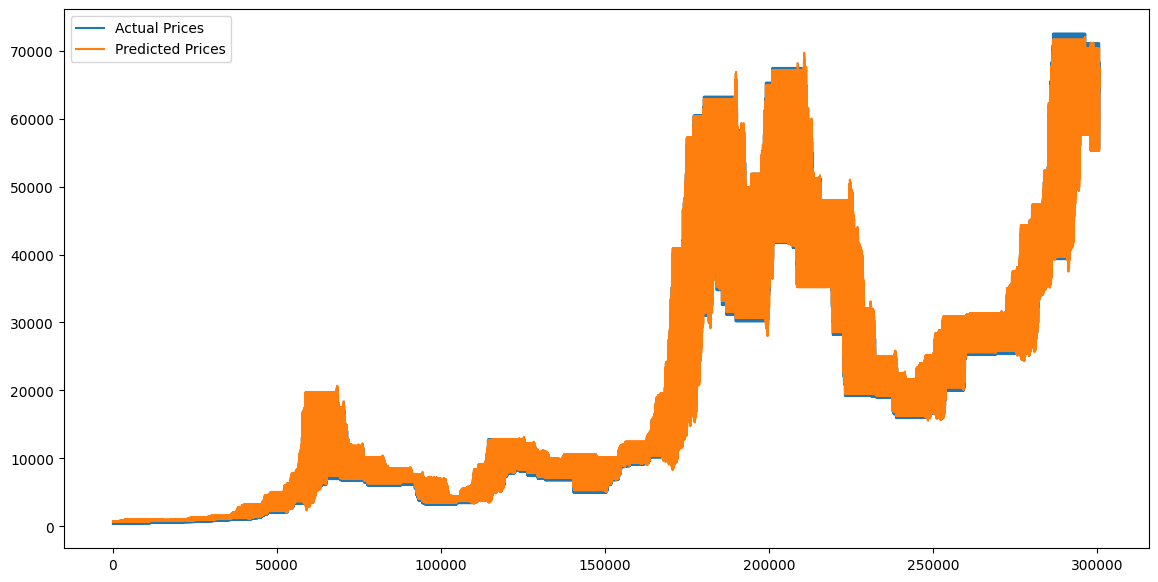

In [29]:
#backtesting 

import numpy as np
import pandas as pd

def backtest(model, data, sequence_length, scaler, start_index, end_index):
    model.eval()
    data = np.array(data)
    predictions = []
    actuals = []

    for i in range(start_index, end_index):
        current_sequence = data[i:i+sequence_length].reshape(1, sequence_length, 1)
        
        with torch.no_grad():
            input_seq = torch.tensor(current_sequence, dtype=torch.float32)
            predicted_value = model(input_seq).item()
        
        predictions.append(predicted_value)
        actuals.append(data[i + sequence_length])
    
    # Invert scaling of predictions and actuals
    predictions = np.array(predictions).reshape(-1, 1)
    predictions = scaler.inverse_transform(predictions).reshape(-1)
    actuals = np.array(actuals).reshape(-1, 1)
    actuals = scaler.inverse_transform(actuals).reshape(-1)

    return actuals, predictions

# Combine train and test data for complete dataset
all_data = np.concatenate((train_data.tensors[0].numpy(), test_data.tensors[0].numpy())).flatten()

# Backtest the model on the test set
start_index = 3000  # Assuming train set ends at 3000
end_index = len(all_data) - sequence_length
actuals, predictions = backtest(model, all_data, sequence_length, scaler, start_index, end_index)

# Create a DataFrame to store actuals and predictions
results = pd.DataFrame({'Actual': actuals, 'Predicted': predictions})

# Calculate performance metrics
results['Difference'] = results['Actual'] - results['Predicted']
results['Pct_Difference'] = results['Difference'] / results['Actual'] * 100

print(results.describe())

# Plot the actual vs. predicted prices
plt.figure(figsize=(14,7))
plt.plot(results['Actual'], label='Actual Prices')
plt.plot(results['Predicted'], label='Predicted Prices')
plt.legend()
plt.show()

In [1]:
import datetime as dt
from features import feature_engineering

start_date = dt.date.today() - dt.timedelta(days=1)
end_date = dt.date.today() - dt.timedelta(days=1)
data = feature_engineering.download_data('BTC-USD', start_date=start_date, end_date=end_date)

[*********************100%%**********************]  1 of 1 completed

1 Failed download:
['BTC-USD']: IndexError('index 0 is out of bounds for axis 0 with size 0')


In [20]:
import yfinance as yf

btc_price = yf.download('BTC-USD', period='1d')

[*********************100%%**********************]  1 of 1 completed


In [22]:
btc_price['Close']

Date
2024-08-12    59312.117188
Name: Close, dtype: float64

In [34]:
def get_bitcoin_price_selected_dates(start_date, end_date):
    return yf.download('BTC-USD', start=start_date, end=end_date)['Close'].values[0]

btc_price = get_bitcoin_price_selected_dates('2024-08-12', '2024-08-13')

[*********************100%%**********************]  1 of 1 completed


In [35]:
btc_price

59005.421875